In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import RayleighBlockFading, cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, AWGN, cir_to_time_channel, time_lag_discrete_time_channel, time_to_ofdm_channel, tr38901
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector, ResourceGrid
from sionna.mimo import StreamManagement
import scipy.special as sp

# For the implementation of the Keras models
from tensorflow.keras import Model

(128, 1, 3)


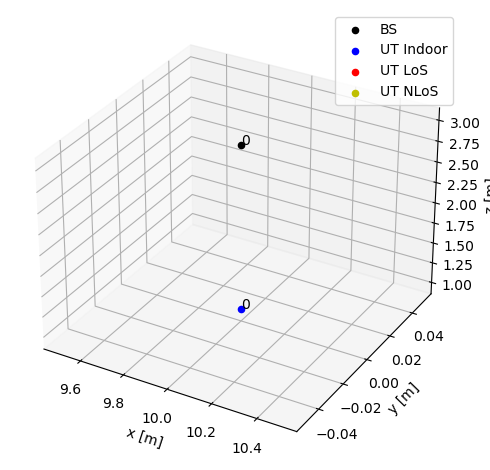

In [4]:
# Setup resource grid and channel model
rg = sionna.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=48,
                                      subcarrier_spacing=30e3,
                                      num_tx=1,
                                      num_streams_per_tx= 1,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])

# UT and BS panel arrays
bs_array = tr38901.PanelArray(num_rows_per_panel = 1,
                      num_cols_per_panel = 1,
                      polarization = 'single',
                      polarization_type = 'V',
                      antenna_pattern = 'omni',
                      carrier_frequency = 3.5e9)

ut_array = tr38901.PanelArray(num_rows_per_panel = 1,
                      num_cols_per_panel = 1,
                      polarization = 'single',
                      polarization_type = 'V',
                      antenna_pattern = 'omni',
                      carrier_frequency = 3.5e9)

# Instantiating RMa channel model
channel_model = tr38901.RMa(carrier_frequency = 3.5e9,
                    ut_array = ut_array,
                    bs_array = bs_array,
                    direction = 'uplink')

# Setting up network topology
# ut_loc: UTs locations
# bs_loc: BSs locations
# ut_orientations: UTs array orientations
# bs_orientations: BSs array orientations
# in_state: Indoor/outdoor states of UTs

batch_size = 128
ut_loc = tf.constant([[[10, 0, 1]]] * batch_size, dtype=tf.float32)
bs_loc = tf.constant([[[10, 0, 3]]] * batch_size, dtype=tf.float32)
ut_orientations = tf.constant([[[0, 0, 0]]] * batch_size, dtype=tf.float32)  # Assuming no orientation for UTs
bs_orientations = tf.constant([[[0, 0, 0]]] * batch_size, dtype=tf.float32)  # Assuming no orientation for BSs
ut_velocities = tf.constant([[[0, 0, 0]]] * batch_size, dtype=tf.float32)  # Assuming no orientation for BSs
num_ut = 1  # Example number of UTs

# Create in_state tensor with all elements set to True
in_state = tf.ones((batch_size, num_ut), dtype=tf.bool)
print(ut_loc.shape)

channel_model.set_topology(ut_loc,
                           bs_loc,
                           ut_orientations,
                           bs_orientations,
                           ut_velocities,
                           in_state)

channel_model.show_topology()

# Instanting the OFDM channel
channel = OFDMChannel(channel_model = channel_model,
                      resource_grid = rg)



In [5]:
BATCH_SIZE = 128
NUM_UT = 1
NUM_STREAMS_PER_TX = 1

RX_TX_ASSOCIATION = np.array([[1]])
STREAM_MANAGEMENT = sionna.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

In [6]:
NUM_BITS_PER_SYMBOL = 4
CODERATE = 1

# Number of coded bits in a resource grid
n = int(rg.num_data_symbols*NUM_BITS_PER_SYMBOL)

print(n)
# Number of information bits in a resource groud
k = int(n*CODERATE)
print(k)

# The binary source will create batches of information bits
binary_source = sionna.utils.BinarySource()

# The encoder maps information bits to coded bits
#encoder = sionna.fec.ldpc.LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = sionna.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = sionna.ofdm.ResourceGridMapper(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = sionna.ofdm.LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = sionna.ofdm.LMMSEEqualizer(rg, STREAM_MANAGEMENT)

# The demapper produces LLR for all coded bits
demapper = sionna.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out = True)

# The decoder provides hard-decisions on the information bits
#decoder = sionna.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

2304
2304


In [7]:
no = sionna.utils.ebnodb2no(ebno_db=3.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE,
                        resource_grid=rg)

print(no)
# Transmitter
bits = binary_source([BATCH_SIZE, NUM_UT, rg.num_streams_per_tx, k])
print("Shape of bits : ", bits.shape)
#codewords = encoder(bits)
#print("Shape of codewords (after encoding): ", codewords.shape)
x = mapper(bits)
print("Shape of x (after mapping): ", x.shape)
x_rg = rg_mapper(x)
print("Shape of x_rg (mapping in Resource Grid): ", x_rg.shape)

# Apply channel
y = channel([x_rg, no]) # Simulate channel output
print("Shape of y_rg (after channel): ", y.shape)

# Receiver
h_hat, err_var = ls_est ([y, no])
print("Shape of h_hat: (after channel enstimation)", h_hat.shape)
print("Shape of err_var (after channel enstimation): ", err_var.shape)
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
print("Shape of x_hat (after channel equalizer): ", x_hat.shape)
print("Shape of no_eff (after channel equalizer): ", no_eff.shape)
bits_hat = demapper([x_hat, no_eff])
print("Shape of bits (after demapping): ", bits_hat.shape)
#bits_hat = decoder(llr)
#print("Shape of bits_hat (after decoding): ", bits_hat.shape)

tf.Tensor(0.16445206, shape=(), dtype=float32)
Shape of bits :  (128, 1, 1, 2304)
Shape of x (after mapping):  (128, 1, 1, 576)
Shape of x_rg (mapping in Resource Grid):  (128, 1, 1, 14, 48)
Shape of y_rg (after channel):  (128, 1, 1, 14, 48)
Shape of h_hat: (after channel enstimation) (128, 1, 1, 1, 1, 14, 48)
Shape of err_var (after channel enstimation):  (1, 1, 1, 1, 1, 14, 48)


InvalidArgumentError: Exception encountered when calling layer 'lmmse_equalizer' (type LMMSEEqualizer).

{{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse] name: 

Call arguments received by layer 'lmmse_equalizer' (type LMMSEEqualizer):
  • inputs=['tf.Tensor(shape=(128, 1, 1, 14, 48), dtype=complex64)', 'tf.Tensor(shape=(128, 1, 1, 1, 1, 14, 48), dtype=complex64)', 'tf.Tensor(shape=(1, 1, 1, 1, 1, 14, 48), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)']

In [ ]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [ ]:
# Generate OFDM channel from CIR
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
print(frequencies)

h = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)
print(h.shape)
h_freq = tf.squeeze(h)

# Generate time channel from CIR
l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
h_time = cir_to_time_channel(rg.bandwidth, a, tau, l_min=l_min, l_max=l_max, normalize=True)

# Generate OFDM channel from time channel
h_freq_hat = tf.squeeze(time_to_ofdm_channel(h_time, rg, l_min))

# Visualize results
plt.figure()
plt.plot(np.real(h_freq), "-")
plt.plot(np.real(h_freq_hat), "--")
plt.plot(np.imag(h_freq), "-")
plt.plot(np.imag(h_freq_hat), "--")
plt.xlabel("Subcarrier index")
plt.ylabel(r"Channel frequency response")
plt.legend(["OFDM Channel (real)", "OFDM Channel from time (real)", "OFDM Channel (imag)", "OFDM Channel from time (imag)"])